# Example use of the pyinfer package

In [1]:
import datetime
import numpy as np
import arviz as az
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon
from pyf3d import Fall3DInputFile, CARRASource, Fall3DBatch, YesNo
from pyem import Emulator
from pywaf import Api
from pyinfer import Forecast

### Fetch $SO_2$ concentration data

2021-07-18.nc exists, loading from local storage.
2021-07-19.nc exists, loading from local storage.
23 stations between 2021-07-18 00:00:00 and 2021-07-20 00:00:00
16 stations measuring SO2
9 within bounding box 63.7 64.3 -23.0 -21.0


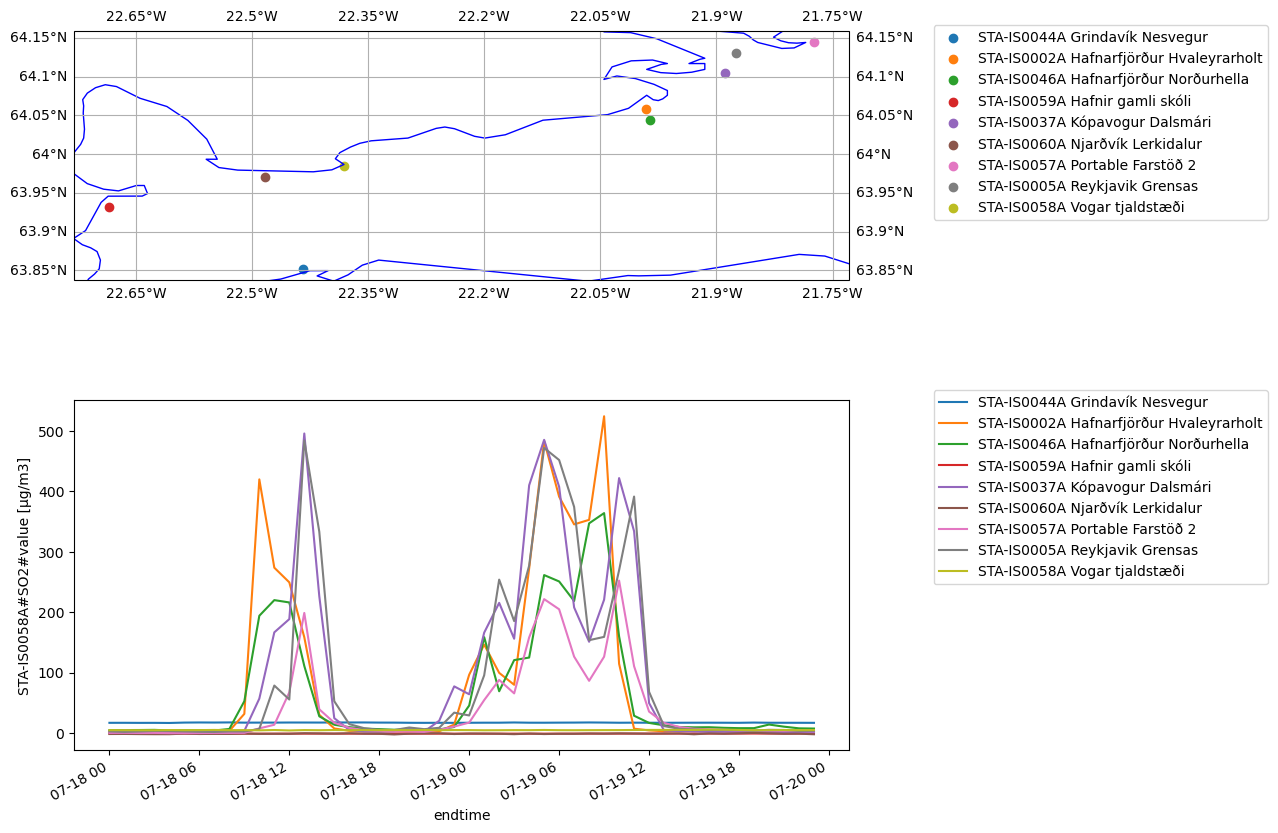

In [2]:
# First we fetch the gas concentration data we need ...

api = Api()

result = api.get_data(
    minlat = 63.7, 
    maxlat = 64.3,
    minlon = -23.0,
    maxlon = -21.0,
    start = datetime.datetime(2021,7,18),
    end = datetime.datetime(2021,7,20),
    #start = datetime.datetime(2021,7,1),
    #end = datetime.datetime(2021,7,5),
    species = 'SO2'
    
)

api.plot_data(result)

### Create an emulator for the duration of the $SO_2$ data

In [3]:
# ... then we get an emulator for the same period. First we need
# a base Fall3D file configured appropriately ...

file = Fall3DInputFile.from_file("mnt/examples/default_so2_reykjanes2.inp")

file.time_utc.update({
    'year':2021,
    'month':7,
    'day':18,
    'run_start':0,
    'run_end':48,
})

file.meteo_data.update({
    'dbs_end_meteo_data':48,
    'meteo_coupling_interval':3*60,
    'meteo_data_file':'mnt/runs/tests3/test3.nc',
    'meteo_data_dictionary_file':'/home/talfan/Software/Fall3D/RUNS/CARRA.tbl',
    'meteo_levels_file':"/home/talfan/Software/Fall3D/RUNS/L137_ECMWF.levels"
     
})
file.model_output.update({
'output_track_points_file':"mnt/runs/library_test1/stations.pts"
})

file.model_physics.update({
    'limiter':'MINMOD'
})

file.emsemble_postprocess.update({
    'postprocess_median':YesNo('no')
})

file.source.update({
    'mass_flow_rate':"1.0"
})


WARNING sigma_values_currently_disabled


In [4]:
# ... which we use to create our emulator ...
em = Emulator(
        basefile=file,
        start=datetime.datetime(year=2021,month=7, day=18),
        hours=48,
        heights = np.arange(0,2550,50).astype(float),
        name = "library_test1",
        path_fall3d = "/home/talfan/Software/Fall3D_local/fall3d/bin/Fall3d.r8.x"
)

In [ ]:
# ... initialising the emulator creates one directory for every run we 
# need to build the emulator lookup table in mnt/runs/<name> ...
em.initialise()

In [ ]:
# ... we then get the meteorological data for each run ...
em.get_meteo_data()

In [ ]:
# ... and run everything.
em.run()

In [5]:
# Once all the runs have finished, build the groudn concentration grid emulator ..
em.build_emulator()

In [6]:
# .. and the emulator for individual stations ...
em.build_station_emulator()

In [12]:
# ... then test the performance of the emulator against
# a random Fall3D run
em.get_emulator_diagnostics(height_low=125.0, height_high=500.0)

WARNING sigma_values_currently_disabled


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.63it/s]

WARNING sigma_values_currently_disabled
File already exists: mnt/runs/library_test1/shared_meteo_data.nc , skipping



hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


-----------------------------------------------------------
                                                           
           ______      _      _      ____  _____           
          |  ____/\   | |    | |    |___ \|  __ \          
          | |__ /  \  | |    | |      __) | |  | |         
          |  __/ /\ \ | |    | |     |__ <| |  | |         
          | | / ____ \| |____| |____ ___) | |__| |         
          |_|/_/    \_\______|______|____/|_____/          
                                                           
                                                           
                 Initializing FALL3D suite                 
                                                           
   Copyright: 2018 GNU General Public License version 3    
                 (see licence for details)                 
                                                           
  Version               : 8.3
  Hardware              : General Purpose (CPU)   
  Input File       

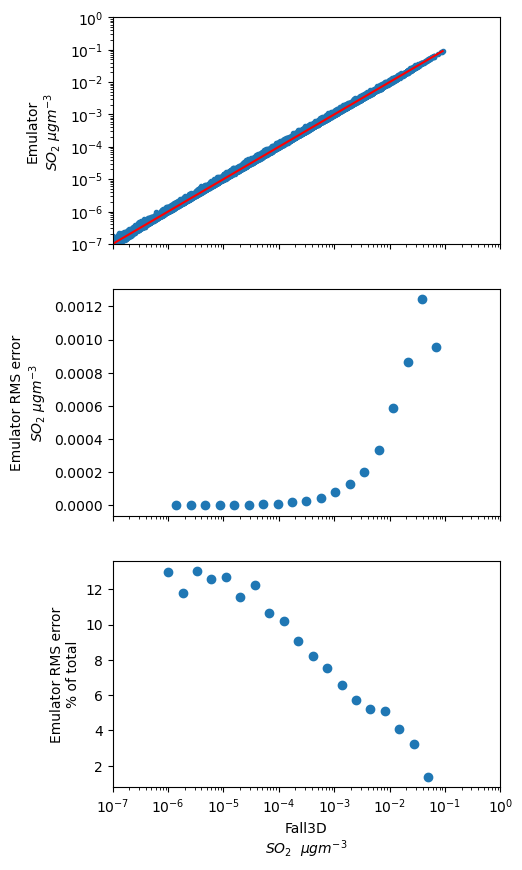

In [13]:
em.plot_emulator_diagnostics()

### Perform Bayesian inference

In [7]:
# The Forecast class provided by the package pyinfer encapsulates the Bayesian inference process,
# which uses the probabilistic programming language Stan (https://mc-stan.org/)

# first we create a new object using the SO2 concentration data and the emulator
forecast = Forecast(emulator=em, observations=result)

In [8]:
# The Bayesian model is specified in the file model.stan in the pyinfer directory
# The data has to be prepared before being passed to stan:
forecast.get_stan_data()

FILTER FOR NEGATIVE SO2 CONC DISABLED!!


In [9]:
# the Stan model then has to be compiled
forecast.load_stan_model()

In [10]:
# we then run the model for the prior ....
forecast.run_prior()

Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan_yg_y4or6/model_zgsqkx3n.stan', line 49, column 15: The
    variable i may not have been assigned a value before its use.
Warning in '/tmp/httpstan_yg_y4or6/model_zgsqkx3n.stan', line 25, column 15: The
    variable i may not have been assigned a value before its use.
    is provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    is provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/6000)
Sampling:   0% (2/6000)
Sampling:   0% (3/6000)
Sampling:   0% (4/6000)
Sampling:   2% (103/6000)
Sampling:   3% (202/6000)
Sampling:   5% (301/6000)
Sampling:   7% (400/60

In [11]:
# ... and the posterior ...
forecast.run_posterior()

Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan_yg_y4or6/model_zgsqkx3n.stan', line 49, column 15: The
    variable i may not have been assigned a value before its use.
Warning in '/tmp/httpstan_yg_y4or6/model_zgsqkx3n.stan', line 25, column 15: The
    variable i may not have been assigned a value before its use.
    is provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    is provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/6000)
Sampling:   0% (2/6000)
Sampling:   0% (3/6000)
Sampling:   0% (4/6000)
Sampling:   2% (103/6000)
Sampling:   3% (202/6000)
Sampling:   5% (301/6000)
Sampling:   7% (400/60

In [12]:
# .. and convert the output to an inferencedata object so arviz (specialised 
# Bayesian model output visualisation library) can work with it
forecast.get_inference_data()

In [13]:
# we inspect the results. First, the prior ...
forecast.summarize_prior()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
height_mu,552.360,168.541,228.238,836.974,17.340,12.436,94.0,186.0,1.04
height_sigma,74.037,51.602,12.900,171.495,11.827,8.494,17.0,189.0,1.19
flux_mu,67.167,9.240,49.978,83.742,0.662,0.473,198.0,643.0,1.01
flux_sigma,23.229,8.115,6.137,36.819,1.128,0.802,53.0,96.0,1.07
height0[2021-07-18T00:02:00.000000000],0.003,0.970,-1.856,1.775,0.022,0.025,1971.0,1199.0,1.01
...,...,...,...,...,...,...,...,...,...
"conc_matrix_hat[STA-IS0060A, 2021-07-19T20:00:00.000000000]",-0.000,0.000,-0.000,0.000,0.000,0.000,2091.0,1848.0,1.00
"conc_matrix_hat[STA-IS0060A, 2021-07-19T21:00:00.000000000]",-0.000,0.000,-0.000,0.000,0.000,0.000,2030.0,1847.0,1.00
"conc_matrix_hat[STA-IS0060A, 2021-07-19T22:00:00.000000000]",0.000,0.000,-0.000,0.000,0.000,0.000,1997.0,1672.0,1.00
"conc_matrix_hat[STA-IS0060A, 2021-07-19T23:00:00.000000000]",-0.000,0.000,-0.000,0.000,0.000,0.000,2132.0,1834.0,1.00


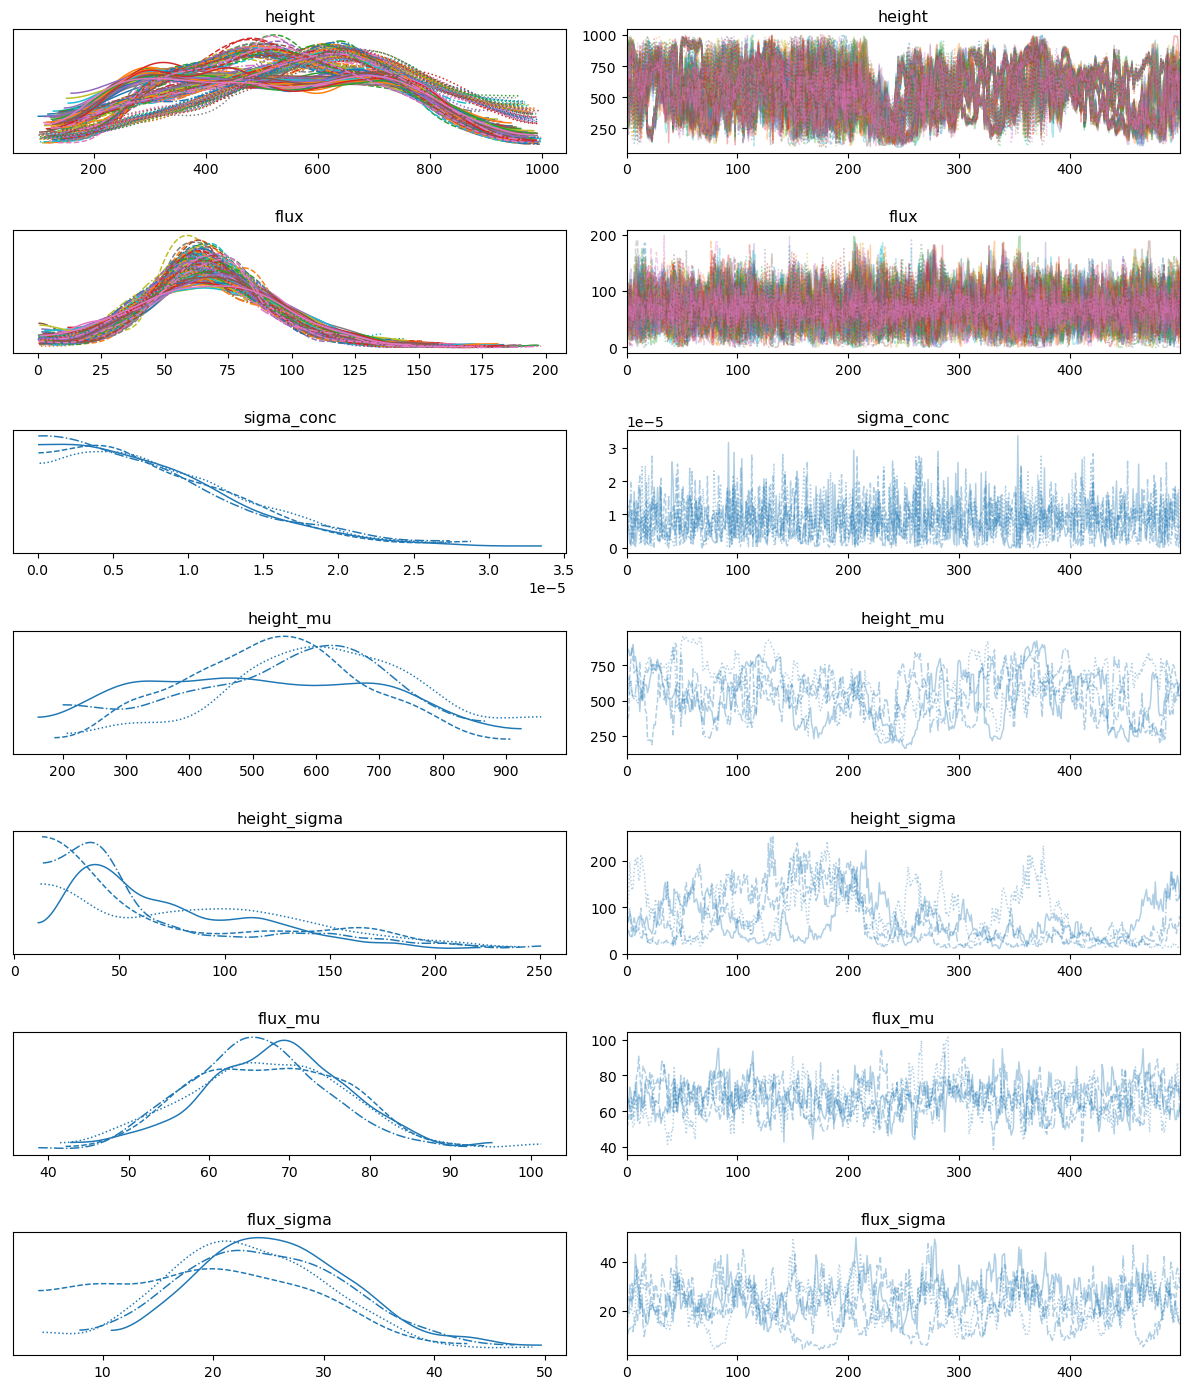

In [14]:
forecast.prior_traceplot()

In [15]:
# ... then the posterior ...
forecast.summarize_posterior()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
height_mu,238.228,38.564,180.331,302.399,4.249,3.015,90.0,111.0,1.05
height_sigma,48.382,29.610,9.040,94.486,4.700,3.348,30.0,69.0,1.10
flux_mu,70.125,9.455,53.544,88.440,0.662,0.469,204.0,557.0,1.02
flux_sigma,24.495,7.952,8.686,38.828,0.880,0.625,84.0,91.0,1.05
height0[2021-07-18T00:02:00.000000000],0.054,0.943,-1.730,1.761,0.020,0.021,2176.0,1307.0,1.00
...,...,...,...,...,...,...,...,...,...
"conc_matrix_hat[STA-IS0060A, 2021-07-19T20:00:00.000000000]",0.000,0.000,-0.000,0.000,0.000,0.000,2037.0,1920.0,1.00
"conc_matrix_hat[STA-IS0060A, 2021-07-19T21:00:00.000000000]",0.000,0.000,-0.000,0.000,0.000,0.000,1945.0,1779.0,1.00
"conc_matrix_hat[STA-IS0060A, 2021-07-19T22:00:00.000000000]",0.000,0.000,-0.000,0.000,0.000,0.000,2015.0,1973.0,1.00
"conc_matrix_hat[STA-IS0060A, 2021-07-19T23:00:00.000000000]",-0.000,0.000,-0.000,0.000,0.000,0.000,1892.0,1856.0,1.00


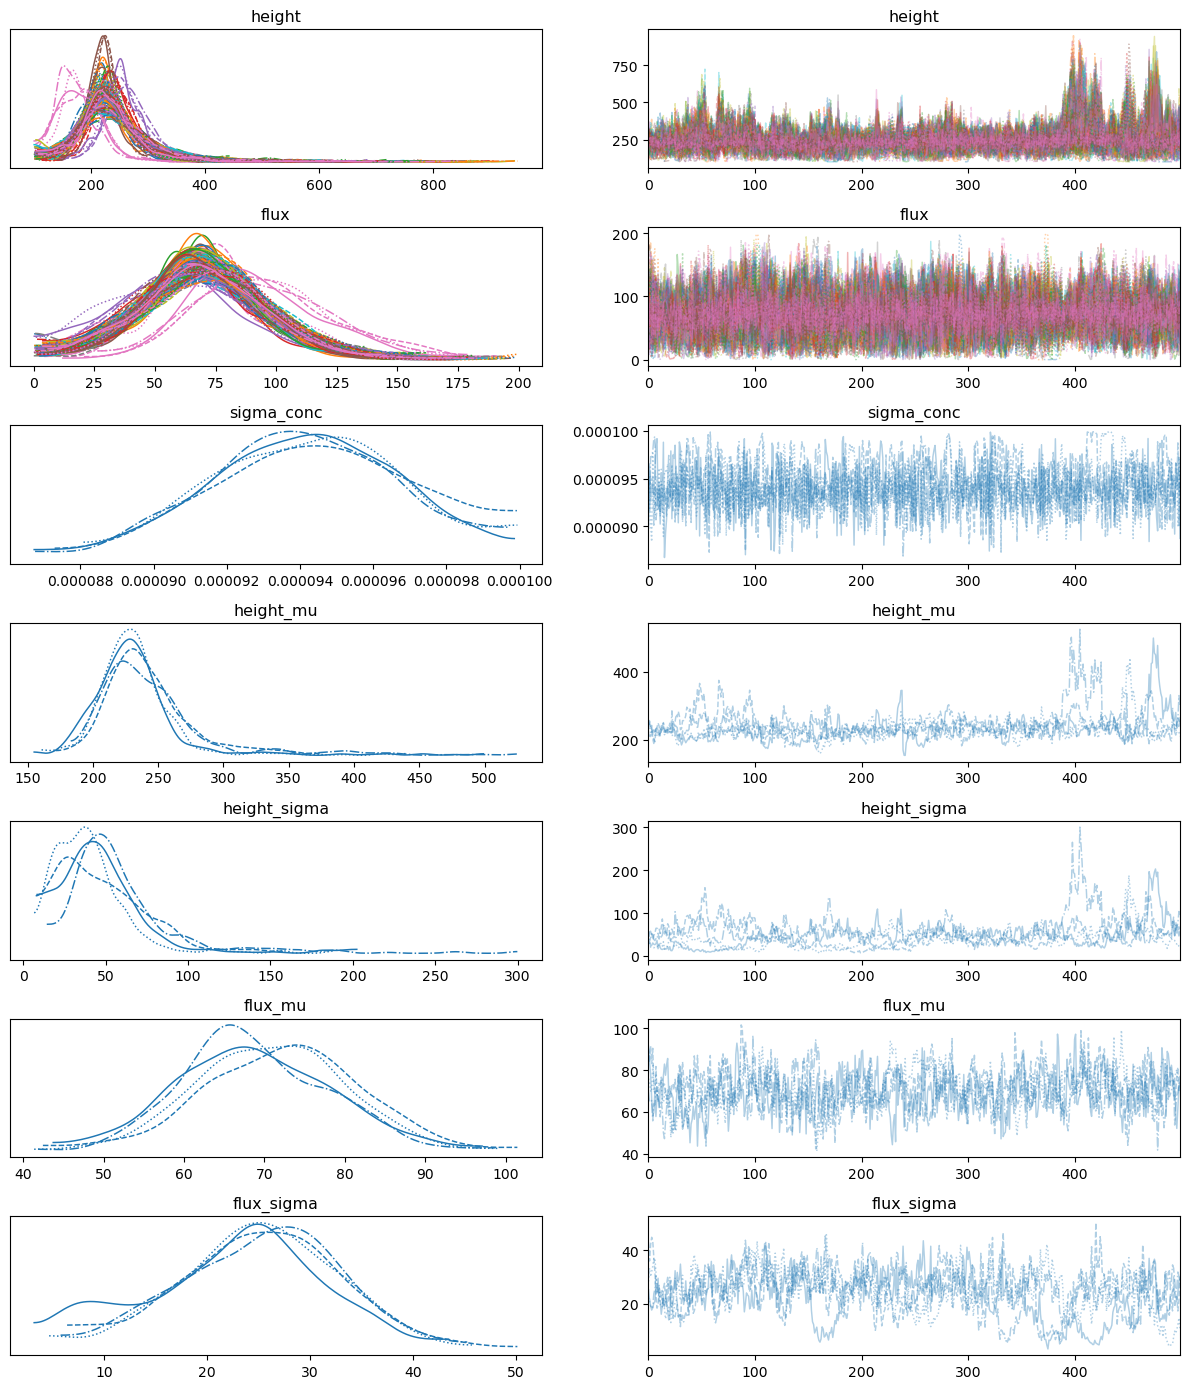

In [16]:
forecast.posterior_traceplot()

### Some visualisations
NOTE! The following is under development and needs to be added as functions 
to the Forecast class

In [20]:
import xarray as xr
concs = []
        
for name in result:
    
    local_id, species, variable = name.split("#")

    if variable == 'value':
        
        concs.append(result[name])
        
        concs[-1].name = local_id

df_obs  = (
            xr
            .merge(concs)
            .to_dataframe()
            .unstack()
            .reset_index()
            .rename(columns={'level_0':'local_id','endtime':'date',0:'conc'})
        )

df_obs = df_obs[
                    (df_obs['date']>= forecast.emulator.da_puff['date'].values[0]) & 
                    (df_obs['date']<= forecast.emulator.da_puff['date'].values[-1])
                ]


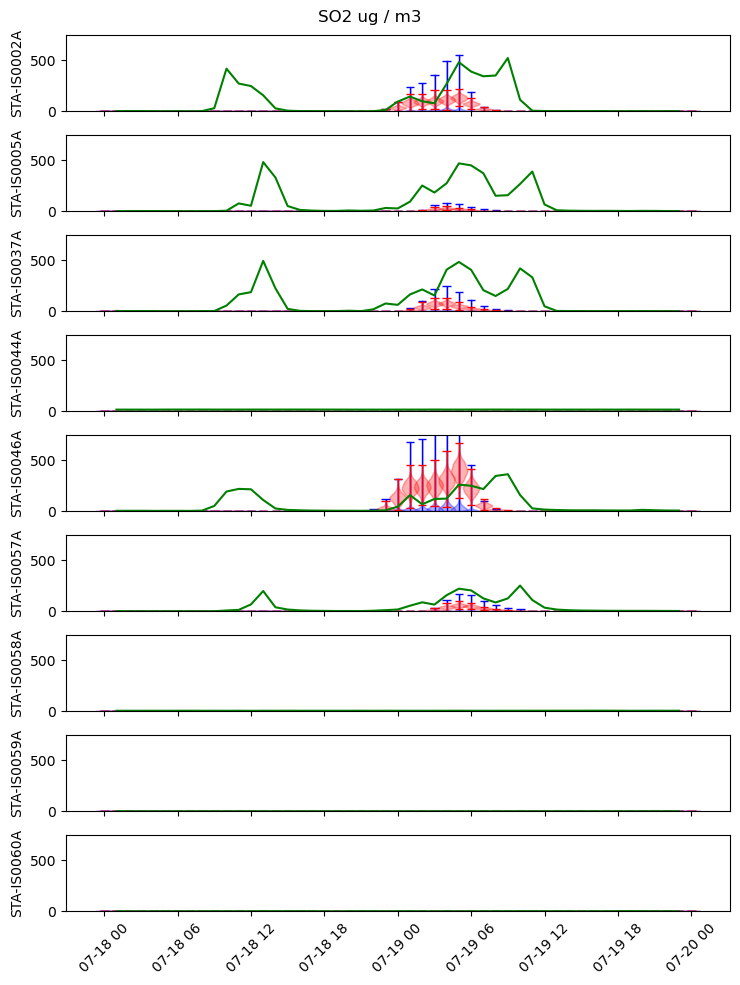

In [21]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

inference_data = forecast.inference_data

local_ids = inference_data.posterior.local_id.values

fig, axs = plt.subplots(len(local_ids),1, sharex=True,  sharey=False,figsize=(7.5,10))





for i, local_id in enumerate(local_ids):

    temp_data = inference_data.prior.conc_matrix.sel(local_id=local_id)

    for j, date in enumerate(temp_data.date.values):
        
        temp_temp_data = temp_data.sel(date=date).stack({'sample':['draw','chain']})
        
        violin_parts = axs[i].violinplot(
            temp_temp_data.values*1e6, 
            positions=[date],
            widths = [np.timedelta64(5000, 's')]
        )        

        for pc in violin_parts['bodies']:
            pc.set_facecolor('blue')
            pc.set_edgecolor('blue')
            
        for partname in ('cbars','cmins','cmaxes'):
            vp = violin_parts[partname]
            vp.set_edgecolor('blue')
            vp.set_linewidth(1)
    

    temp_data = inference_data.posterior.conc_matrix.sel(local_id=local_id)

    for j, date in enumerate(temp_data.date.values):
        
        temp_temp_data = temp_data.sel(date=date).stack({'sample':['draw','chain']})
        
        violin_parts = axs[i].violinplot(
            temp_temp_data.values*1e6, 
            positions=[date],
            widths = [np.timedelta64(5000, 's')]
        )        

        for pc in violin_parts['bodies']:
            pc.set_facecolor('red')
            pc.set_edgecolor('red')
            
        for partname in ('cbars','cmins','cmaxes'):
            vp = violin_parts[partname]
            vp.set_edgecolor('red')
            vp.set_linewidth(1)

    

    df_temp = df_obs[df_obs['local_id']==local_id].reset_index(drop=True)
    
    axs[i].plot(
        df_temp['date'],
        df_temp['conc'],
        color='green')

    axs[i].set_ylabel(local_id)

    axs[i].tick_params(axis='x', labelrotation=45)

for ax in axs:
    
    ax.set_ylim([0,750])

    

fig.suptitle("SO2 ug / m3")
plt.tight_layout()

In [23]:
ds_temp = (inference_data
             .prior
             .stack(
                 dimensions={'sample':['chain','draw']},
             )[['height','flux']]
            )


all_samples_prior = []

for s in range(len(ds_temp.sample)):
    #print(s)

    temp = ds_temp.isel(sample=s)

    heights = temp.height.values

    fluxes = temp.flux.values

    list_puffs_per_sample = []

    for i in range(len(heights)):
        list_puffs_per_sample.append(
            em.da_emulator.isel(source_start=i).interp(height_above_vent=heights[i],method='linear')*fluxes[i]
        )

    all_samples_prior.append(
        sum(list_puffs_per_sample)
    )

In [24]:
ds_temp = (inference_data
             .posterior
             .stack(
                 dimensions={'sample':['chain','draw']},
             )[['height','flux']]
            )


all_samples_posterior = []

for s in range(len(ds_temp.sample)):
   # print(s)

    temp = ds_temp.isel(sample=s)

    heights = temp.height.values

    fluxes = temp.flux.values

    list_puffs_per_sample = []

    for i in range(len(heights)):
        list_puffs_per_sample.append(
            em.da_emulator.isel(source_start=i).interp(height_above_vent=heights[i],method='linear')*fluxes[i]
        )

    all_samples_posterior.append(
        sum(list_puffs_per_sample)
    )

In [25]:
exceedance_prior = sum([ all_sample>250e-6 for all_sample in  all_samples_prior])

In [26]:
exceedance_posterior = sum([ all_sample>250e-6 for all_sample in  all_samples_posterior])

<>:11: SyntaxWarning: invalid escape sequence '\m'
<>:14: SyntaxWarning: invalid escape sequence '\m'
<>:18: SyntaxWarning: invalid escape sequence '\m'
<>:11: SyntaxWarning: invalid escape sequence '\m'
<>:14: SyntaxWarning: invalid escape sequence '\m'
<>:18: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_1618108/765141591.py:11: SyntaxWarning: invalid escape sequence '\m'
  'label':'Probability of exceeding 1000 $\mu g m^{-3}$  $SO_{2}$'
/tmp/ipykernel_1618108/765141591.py:14: SyntaxWarning: invalid escape sequence '\m'
  cbar_kwargs = {'orientation':'horizontal', 'shrink':0.6, 'aspect':40, 'label':'Prior probability of exceeding 1000 $\mu g$ $SO_2$'}
/tmp/ipykernel_1618108/765141591.py:18: SyntaxWarning: invalid escape sequence '\m'
  cbar_kwargs = {'orientation':'horizontal', 'shrink':0.6, 'aspect':40, 'label':'Posterior probability of exceeding 1000 $\mu g$ $SO_2$'}


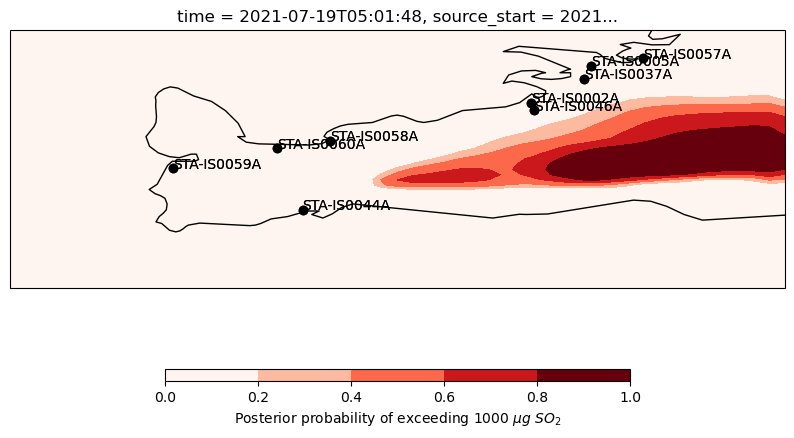

In [27]:
import cartopy
# Plot Chlor_a data
fig = plt.figure(figsize=(10, 7))
map_projection = cartopy.crs.PlateCarree()

ax = plt.axes(projection=map_projection)
cbar_kwargs = {
    'orientation':'horizontal', 
    'shrink':0.8, 
    'aspect':40, 
    'label':'Probability of exceeding 1000 $\mu g m^{-3}$  $SO_{2}$'
}

cbar_kwargs = {'orientation':'horizontal', 'shrink':0.6, 'aspect':40, 'label':'Prior probability of exceeding 1000 $\mu g$ $SO_2$'}

#(exceedance_prior/2000).isel(time=-9).plot.contourf(x='lon',y='lat',ax=ax,cmap='Blues', levels=6, cbar_kwargs=cbar_kwargs)

cbar_kwargs = {'orientation':'horizontal', 'shrink':0.6, 'aspect':40, 'label':'Posterior probability of exceeding 1000 $\mu g$ $SO_2$'}

(exceedance_prior/2000).isel(time=-20).plot.contourf(
    x='lon',
    y='lat',
    ax=ax, 
    cmap='Reds',
    levels=6,
    cbar_kwargs=cbar_kwargs
)

ax.coastlines(color='black')

#ax.set_xticks(np.linspace(-85, -55, 5), crs=map_projection)
#ax.set_yticks(np.linspace(26, 48, 5), crs=map_projection)
#lon_formatter = LongitudeFormatter(zero_direction_label=True)
#lat_formatter = LatitudeFormatter()
#ax.xaxis.set_major_formatter(lon_formatter)
#ax.yaxis.set_major_formatter(lat_formatter)

#plt.colorbar(im, label='log10(Chlorophyll-a)')
#plt.title(ds.time_coverage_start)
for name in result:
    lat = result[name].attrs['lat']
    lon = result[name].attrs['lon']
    local_id = name.split("#")[0]
    ax.scatter(lon,lat,color='black')
    ax.text(lon, lat, local_id, fontdict={'color':'black'})

<>:11: SyntaxWarning: invalid escape sequence '\m'
<>:14: SyntaxWarning: invalid escape sequence '\m'
<>:18: SyntaxWarning: invalid escape sequence '\m'
<>:11: SyntaxWarning: invalid escape sequence '\m'
<>:14: SyntaxWarning: invalid escape sequence '\m'
<>:18: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_1618108/1980437517.py:11: SyntaxWarning: invalid escape sequence '\m'
  'label':'Probability of exceeding 1000 $\mu g m^{-3}$  $SO_{2}$'
/tmp/ipykernel_1618108/1980437517.py:14: SyntaxWarning: invalid escape sequence '\m'
  cbar_kwargs = {'orientation':'horizontal', 'shrink':0.6, 'aspect':40, 'label':'Prior probability of exceeding 1000 $\mu g$ $SO_2$'}
/tmp/ipykernel_1618108/1980437517.py:18: SyntaxWarning: invalid escape sequence '\m'
  cbar_kwargs = {'orientation':'horizontal', 'shrink':0.6, 'aspect':40, 'label':'Posterior probability of exceeding 1000 $\mu g$ $SO_2$'}


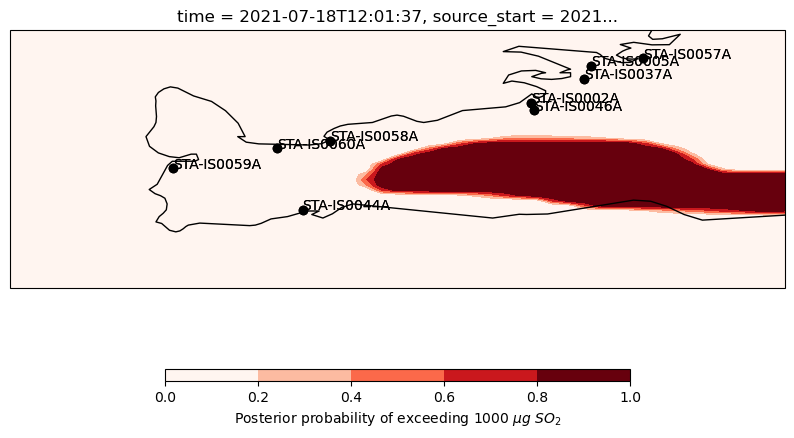

In [28]:
import cartopy
# Plot Chlor_a data
fig = plt.figure(figsize=(10, 7))
map_projection = cartopy.crs.PlateCarree()

ax = plt.axes(projection=map_projection)
cbar_kwargs = {
    'orientation':'horizontal', 
    'shrink':0.8, 
    'aspect':40, 
    'label':'Probability of exceeding 1000 $\mu g m^{-3}$  $SO_{2}$'
}

cbar_kwargs = {'orientation':'horizontal', 'shrink':0.6, 'aspect':40, 'label':'Prior probability of exceeding 1000 $\mu g$ $SO_2$'}

#(exceedance_prior/2000).isel(time=-9).plot.contourf(x='lon',y='lat',ax=ax,cmap='Blues', levels=6, cbar_kwargs=cbar_kwargs)

cbar_kwargs = {'orientation':'horizontal', 'shrink':0.6, 'aspect':40, 'label':'Posterior probability of exceeding 1000 $\mu g$ $SO_2$'}

(exceedance_posterior/2000).isel(time=12).plot.contourf(
    x='lon',
    y='lat',
    ax=ax, 
    cmap='Reds',
    levels=6,
    cbar_kwargs=cbar_kwargs
)

ax.coastlines(color='black')

#ax.set_xticks(np.linspace(-85, -55, 5), crs=map_projection)
#ax.set_yticks(np.linspace(26, 48, 5), crs=map_projection)
#lon_formatter = LongitudeFormatter(zero_direction_label=True)
#lat_formatter = LatitudeFormatter()
#ax.xaxis.set_major_formatter(lon_formatter)
#ax.yaxis.set_major_formatter(lat_formatter)

#plt.colorbar(im, label='log10(Chlorophyll-a)')
#plt.title(ds.time_coverage_start)
for name in result:
    lat = result[name].attrs['lat']
    lon = result[name].attrs['lon']
    local_id = name.split("#")[0]
    ax.scatter(lon,lat,color='black')
    ax.text(lon, lat, local_id, fontdict={'color':'black'})

[<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >]


/tmp/ipykernel_1618108/2719864963.py:408: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in sample_map.collections:


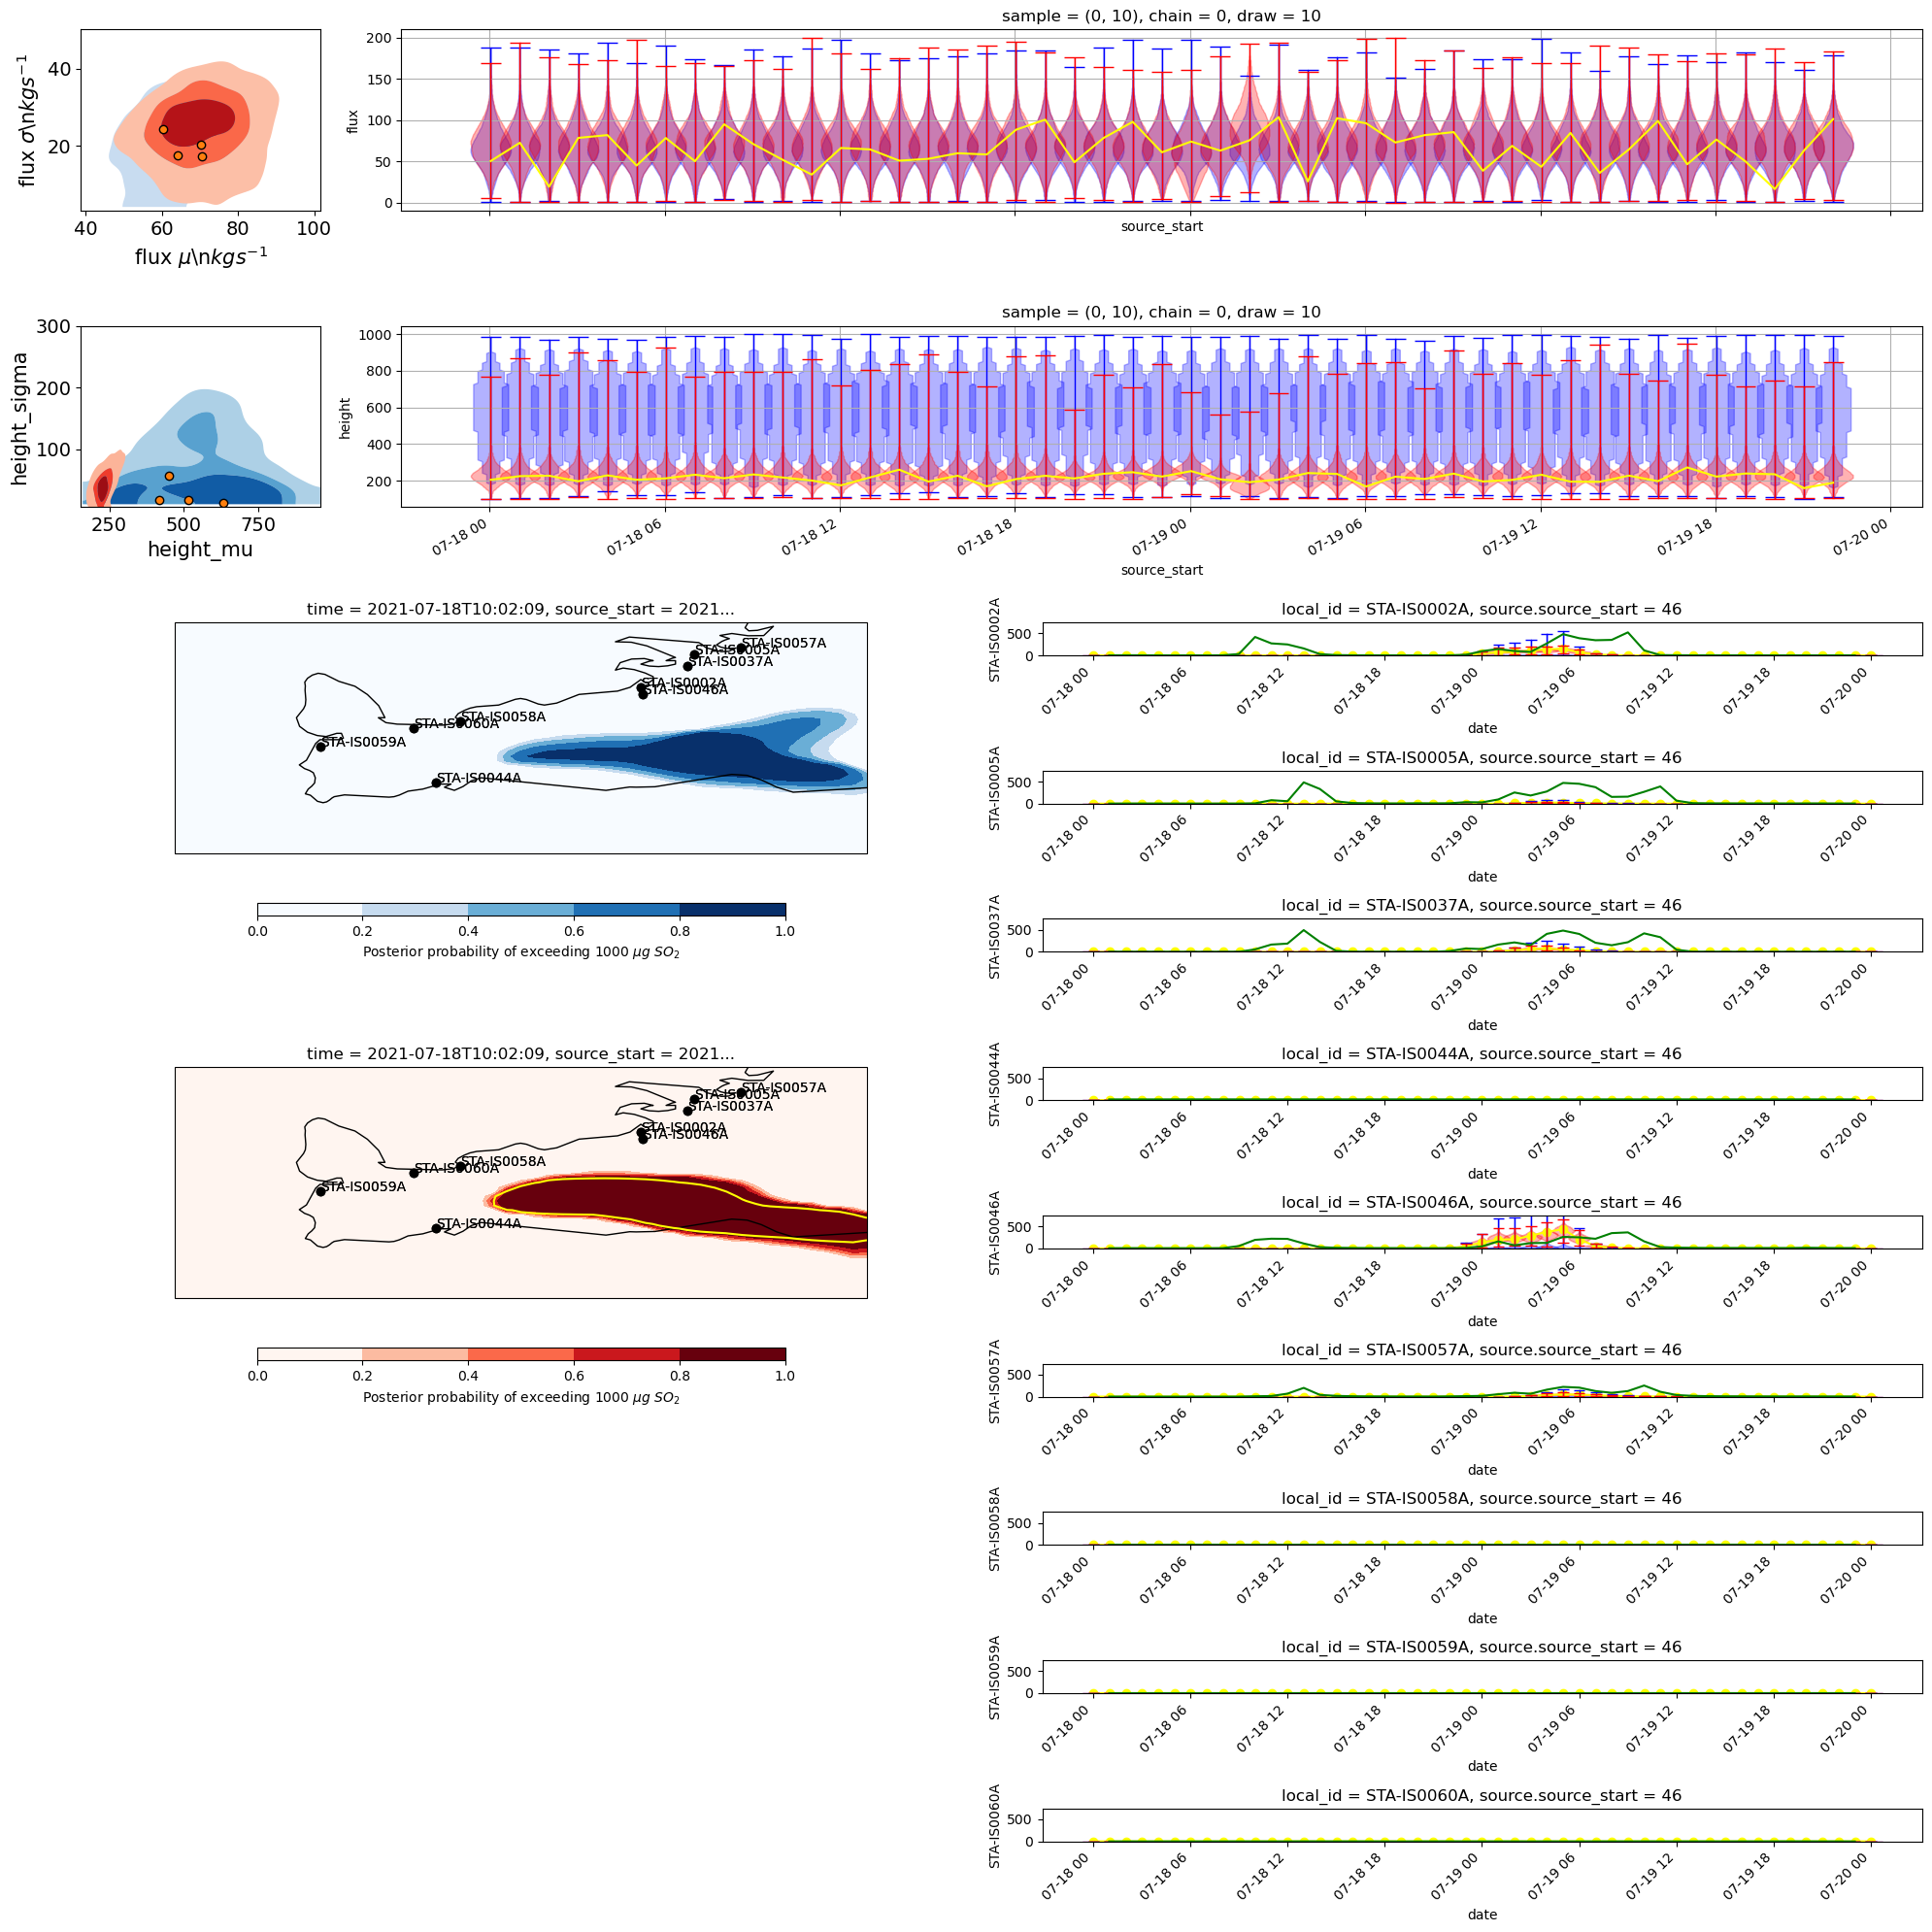

In [30]:
import cartopy.crs as ccrs


sample = 10
time = 10


fig = plt.figure(figsize=(20,20))

gs = fig.add_gridspec(max(8, 4+len(local_ids)),12) # rows, columns

ax_flux_hyper = fig.add_subplot(gs[0:2,0:2])
ax_flux       = fig.add_subplot(gs[0:2,2:])

ax_height_hyper       = fig.add_subplot(gs[2:4,0:2])
ax_height = fig.add_subplot(gs[2:4,2:], sharex=ax_flux)

ax_map_prior = fig.add_subplot(gs[4:7,:6],projection = ccrs.PlateCarree())
ax_map_posterior = fig.add_subplot(gs[7:10,:6],projection = ccrs.PlateCarree())

axs = [fig.add_subplot(gs[i+4,6:]) for i in range(max(4,len(local_ids)))]


#for ax in axs[1:]:
#    ax.sharex(axs[0])
#    ax.set_xticklabels([])
#    ax.autoscale()



    
print(axs)

ax_flux.grid()
ax_height.grid()

az.plot_pair(inference_data,
             group='prior',
            var_names=['flux_mu', 'flux_sigma'],
            kind='kde',
            divergences=True,
            #textsize=12,
            ax=ax_flux_hyper,
            kde_kwargs={
        "hdi_probs": [0.3, 0.6, 0.9],  # Plot 30%, 60% and 90% HDI contours
        "contourf_kwargs": {"cmap": "Blues"},
        "contour_kwargs": {"cmap": "Blues",'colors':None,'alpha':0},
    })

az.plot_pair(inference_data,
             group='posterior',
            var_names=['flux_mu', 'flux_sigma'],
            kind='kde',
            divergences=True,
            #textsize=12,
            ax=ax_flux_hyper,
            kde_kwargs={
        "hdi_probs": [0.3, 0.6, 0.9],  # Plot 30%, 60% and 90% HDI contours
        "contourf_kwargs": {"cmap": "Reds"},
                        "contour_kwargs": {"cmap": "Reds",'colors':None,'alpha':0},
    })

ax_flux_hyper.set_ylabel(r"flux $\sigma$\n$kgs^{-1}$")
ax_flux_hyper.set_xlabel(r"flux $\mu$\n$kgs^{-1}$")



temp_data = inference_data.prior.flux


for j, source_start in enumerate(temp_data.source_start.values):
    
    temp_temp_data = temp_data.sel(source_start=source_start).stack({'sample':['draw','chain']})
    
    violin_parts = ax_flux.violinplot(
        temp_temp_data.values, 
        positions=[source_start],
        widths = [np.timedelta64(5000, 's')]
    )        

    for pc in violin_parts['bodies']:
        pc.set_facecolor('blue')
        pc.set_edgecolor('blue')
        
    for partname in ('cbars','cmins','cmaxes'):
        vp = violin_parts[partname]
        vp.set_edgecolor('blue')
        vp.set_linewidth(1)



temp_data = inference_data.posterior.flux


for j, source_start in enumerate(temp_data.source_start.values):
    
    temp_temp_data = temp_data.sel(source_start=source_start).stack({'sample':['draw','chain']})
    
    violin_parts = ax_flux.violinplot(
        temp_temp_data.values, 
        positions=[source_start],
        widths = [np.timedelta64(5000, 's')]
    )        

    for pc in violin_parts['bodies']:
        pc.set_facecolor('red')
        pc.set_edgecolor('red')
        
    for partname in ('cbars','cmins','cmaxes'):
        vp = violin_parts[partname]
        vp.set_edgecolor('red')
        vp.set_linewidth(1)







temp_data = inference_data.prior.height

for j, source_start in enumerate(temp_data.source_start.values):
    
    temp_temp_data = temp_data.sel(source_start=source_start).stack({'sample':['draw','chain']})
    
    violin_parts = ax_height.violinplot(
        temp_temp_data.values, 
        positions=[source_start],
        widths = [np.timedelta64(5000, 's')]
    )        

    for pc in violin_parts['bodies']:
        pc.set_facecolor('blue')
        pc.set_edgecolor('blue')
        
    for partname in ('cbars','cmins','cmaxes'):
        vp = violin_parts[partname]
        vp.set_edgecolor('blue')
        vp.set_linewidth(1)
    



temp_data = inference_data.posterior.height

for j, source_start in enumerate(temp_data.source_start.values):
    
    temp_temp_data = temp_data.sel(source_start=source_start).stack({'sample':['draw','chain']})
    
    violin_parts = ax_height.violinplot(
        temp_temp_data.values, 
        positions=[source_start],
        widths = [np.timedelta64(5000, 's')]
    )        

    for pc in violin_parts['bodies']:
        pc.set_facecolor('red')
        pc.set_edgecolor('red')
        
    for partname in ('cbars','cmins','cmaxes'):
        vp = violin_parts[partname]
        vp.set_edgecolor('red')
        vp.set_linewidth(1)





az.plot_pair(inference_data,
             group='prior',
            var_names=['height_mu', 'height_sigma'],
            kind='kde',
            divergences=True,
            #textsize=12,
            ax=ax_height_hyper,
            kde_kwargs={
        "hdi_probs": [0.3, 0.6, 0.9],  # Plot 30%, 60% and 90% HDI contours
        "contourf_kwargs": {"cmap": "Blues"},
        "contour_kwargs": {"cmap": "Blues",'colors':None,'alpha':0},
    })

az.plot_pair(inference_data,
             group='posterior',
            var_names=['height_mu', 'height_sigma'],
            kind='kde',
            divergences=True,
            #textsize=12,
            ax=ax_height_hyper,
            kde_kwargs={
        "hdi_probs": [0.3, 0.6, 0.9],  # Plot 30%, 60% and 90% HDI contours
        "contourf_kwargs": {"cmap": "Reds"},
                        "contour_kwargs": {"cmap": "Reds",'colors':None,'alpha':0},
    })

ax_flux_hyper.set_ylabel(r"flux $\sigma$\n$kgs^{-1}$")
ax_flux_hyper.set_xlabel(r"flux $\mu$\n$kgs^{-1}$")


cbar_kwargs = {
    'orientation':'horizontal', 
    'shrink':0.8, 
    'aspect':40, 
    'label':r'Probability of exceeding 1000 $\mu g m^{-3}$  $SO_{2}$'
}

cbar_kwargs = {'orientation':'horizontal', 'shrink':0.6, 'aspect':40, 'label':r'Prior probability of exceeding 1000 $\mu g$ $SO_2$'}

#(exceedance_prior/2000).isel(time=-9).plot.contourf(x='lon',y='lat',ax=ax,cmap='Blues', levels=6, cbar_kwargs=cbar_kwargs)

cbar_kwargs = {'orientation':'horizontal', 'shrink':0.6, 'aspect':40, 'label':r'Posterior probability of exceeding 1000 $\mu g$ $SO_2$'}

map_exceedance_prior = (exceedance_prior/2000).isel(time=time).plot.contourf(
    x='lon',
    y='lat',
    ax=ax_map_prior, 
    cmap='Blues',
    levels=6,
    cbar_kwargs=cbar_kwargs
)


map_exceedance_posterior = (exceedance_posterior/2000).isel(time=time).plot.contourf(
    x='lon',
    y='lat',
    ax=ax_map_posterior, 
    cmap='Reds',
    levels=6,
    #alpha=0.5
    cbar_kwargs=cbar_kwargs
)

ax_map_prior.coastlines(color='black')
ax_map_posterior.coastlines(color='black')

ax_map_prior.set_facecolor('lightgrey')
ax_map_posterior.set_facecolor('lightgrey')


#ax.set_xticks(np.linspace(-85, -55, 5), crs=map_projection)
#ax.set_yticks(np.linspace(26, 48, 5), crs=map_projection)
#lon_formatter = LongitudeFormatter(zero_direction_label=True)
#lat_formatter = LatitudeFormatter()
#ax.xaxis.set_major_formatter(lon_formatter)
#ax.yaxis.set_major_formatter(lat_formatter)

#plt.colorbar(im, label='log10(Chlorophyll-a)')
#plt.title(ds.time_coverage_start)
for name in result:
    lat = result[name].attrs['lat']
    lon = result[name].attrs['lon']
    local_id = name.split("#")[0]
    ax_map_prior.scatter(lon,lat,color='black')
    ax_map_prior.text(lon, lat, local_id, fontdict={'color':'black'})
    ax_map_posterior.scatter(lon,lat,color='black')
    ax_map_posterior.text(lon, lat, local_id, fontdict={'color':'black'})    



sample_height, = inference_data.posterior['height'].stack({'sample':['chain','draw']}).isel(sample=sample).plot(ax=ax_height,color='yellow')

sample_flux, = inference_data.posterior['flux'].stack({'sample':['chain','draw']}).isel(sample=sample).plot(ax=ax_flux,color='yellow')




################################################################################################################################


ds_posterior_esps = inference_data.posterior[['height','flux']].stack({'sample':['chain','draw']})

def get_data_for_sample(sample):
    df_test = ds_posterior_esps.isel(sample=sample).to_dataframe().reset_index()
    df_test = df_test.rename(columns={"height":"height_above_vent"})
    df_test['source_start'] = df_test['source_start'].apply(lambda r: datetime.datetime(r.year,r.month,r.day,r.hour))
    
    da_test = em.estimate(df_test)
    
    df_test['source_start'] = (
                            df_test['source_start']
                            .apply(lambda r: (r - df_test['source_start'].iloc[0]))
                            .dt
                            .total_seconds()/(60*60)
                        ).astype(int)
    da_test_station= em.estimate_stations(df_test)
    
    da_test_station = da_test_station*1e6

    return(da_test, da_test_station)

da_test, da_test_station = get_data_for_sample(sample)


sample_map = da_test.isel(time=time).plot.contour(
    ax=ax_map_posterior,
    x='lon',
    y='lat',
    cmap='yellow',
    levels=6
)


#df_test = df_test.rename(columns={
   # 'source_start':'source.source_start',
#    'height_above_vent':'source.height_above_vent'
#})


for i, local_id in enumerate(local_ids):

    da_test_station.sel(local_id=local_id).plot(ax=axs[i], color='yellow',marker='o')

    

###########################################################################################################################################################




for i, local_id in enumerate(local_ids):

    temp_data = inference_data.prior.conc_matrix.sel(local_id=local_id)

    for j, date in enumerate(temp_data.date.values):
        
        temp_temp_data = temp_data.sel(date=date).stack({'sample':['draw','chain']})
        
        violin_parts = axs[i].violinplot(
            temp_temp_data.values*1e6, 
            positions=[date],
            widths = [np.timedelta64(5000, 's')]
        )        

        for pc in violin_parts['bodies']:
            pc.set_facecolor('blue')
            pc.set_edgecolor('blue')
            
        for partname in ('cbars','cmins','cmaxes'):
            vp = violin_parts[partname]
            vp.set_edgecolor('blue')
            vp.set_linewidth(1)
    

    temp_data = inference_data.posterior.conc_matrix.sel(local_id=local_id)

    for j, date in enumerate(temp_data.date.values):
        
        temp_temp_data = temp_data.sel(date=date).stack({'sample':['draw','chain']})
        
        violin_parts = axs[i].violinplot(
            temp_temp_data.values*1e6, 
            positions=[date],
            widths = [np.timedelta64(5000, 's')]
        )        

        for pc in violin_parts['bodies']:
            pc.set_facecolor('red')
            pc.set_edgecolor('red')
            
        for partname in ('cbars','cmins','cmaxes'):
            vp = violin_parts[partname]
            vp.set_edgecolor('red')
            vp.set_linewidth(1)

    

    df_temp = df_obs[df_obs['local_id']==local_id].reset_index(drop=True)
    
    axs[i].plot(
        df_temp['date'],
        df_temp['conc'],
        color='green')

    axs[i].set_ylabel(local_id)

    axs[i].tick_params(axis='x', labelrotation=45)

for ax in axs:
    
    ax.set_ylim([0,750])



plt.setp(ax_flux.get_xticklabels(), visible=False)

plt.tight_layout()

##return da_test_station

#da_test_station = fun(100)



def fun(sample, time):
    
    global sample_map
    global map_exceedance_posterior
    global map_exceedance_prior
    global ax_map_prior, ax_map_posterior

    da_test, da_test_station = get_data_for_sample(sample)

    height_temp = ds_posterior_esps['height'].isel(sample=sample)
    flux_temp = ds_posterior_esps['flux'].isel(sample=sample)
    
    sample_height.set_data(height_temp.source_start, height_temp.values)
    sample_flux.set_data(flux_temp.source_start, flux_temp.values)

    for c in sample_map.collections:
        try:
            c.remove()
        except ValueError:
            pass


    try:
        map_exceedance_posterior.colorbar.remove()
    except:
        pass

    try:
        map_exceedance_prior.colorbar.remove()
    except:
        pass


    ax_map_prior.clear()    
    ax_map_posterior.clear()


    ax_map_prior.autoscale()    
    ax_map_posterior.autoscale()
    
    map_exceedance_prior = (exceedance_prior/2000).isel(time=time).plot.contourf(
        x='lon',
        y='lat',
        ax=ax_map_prior, 
        cmap='Blues',
        levels=6,
        cbar_kwargs=cbar_kwargs
    )
    
    
    map_exceedance_posterior = (exceedance_posterior/2000).isel(time=time).plot.contourf(
        x='lon',
        y='lat',
        ax=ax_map_posterior, 
        cmap='Reds',
        levels=6,
        #alpha=0.5
        cbar_kwargs=cbar_kwargs
    )

    
    sample_map = da_test.isel(time=time).plot.contour(
        ax=ax_map_posterior,
        x='lon',
        y='lat',
        cmap='yellow',
        levels=[1000e-6],#6
    )

    for name in result:
        lat = result[name].attrs['lat']
        lon = result[name].attrs['lon']
        local_id = name.split("#")[0]
        ax_map_prior.scatter(lon,lat,color='black')
        ax_map_prior.text(lon, lat, local_id, fontdict={'color':'black'})
        ax_map_posterior.scatter(lon,lat,color='black')
        ax_map_posterior.text(lon, lat, local_id, fontdict={'color':'black'})   
        #ax_map_posterior.clabel(sample_map)

    ax_map_posterior.coastlines()
    ax_map_prior.coastlines()


    return fig

fun(10, 10);
